<a href="https://colab.research.google.com/github/AIS-SG/ai_lab_224n_NLP/blob/main/%EC%96%91%EB%B0%A9%ED%96%A5_LSTM%EC%9D%84_%EC%9D%B4%EC%9A%A9%ED%95%9C_%ED%92%88%EC%82%AC_%ED%83%9C%EA%B9%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 딥러닝을 이용한 자연어 처리 입문 - 양방향 LSTM을 이용한 품사 태깅
##### 참고자료 : https://wikidocs.net/33532

## 품사 태깅 데이터에 대한 이해와 전처리

In [1]:
import nltk
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [3]:
nltk.download('treebank')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.


True

##### 영어 코퍼스에 토큰화와 품사 태깅 전처리를 진행한 문장 데이터를 받아올 수 있다.

In [4]:
tagged_sentences = nltk.corpus.treebank.tagged_sents() # 토큰화에 품사 태깅이 된 데이터 받아오기
print("품사 태깅이 된 문장 개수: ", len(tagged_sentences)) # 문장 샘플의 개수 출력

품사 태깅이 된 문장 개수:  3914


In [5]:
print(tagged_sentences[0]) # 첫번째 샘플 출력

[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')]


##### 훈련을 시키려면 훈련 데이터에서 단어에 해당되는 부분과 품사 태깅 정보에 해당되는 부분을 분리시켜야 한다.

In [6]:
sentences, pos_tags = [], [] 
for tagged_sentence in tagged_sentences: # 3,914개의 문장 샘플을 1개씩 불러온다.
    sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에 품사 태깅 정보들은 tag_info에 저장한다.
    sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장한다.
    pos_tags.append(list(tag_info)) # 각 샘플에서 품사 태깅 정보만 저장한다.

In [7]:
print(sentences[0])
print(pos_tags[0])

['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']
['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.']


In [8]:
print(sentences[8])
print(pos_tags[8])

['We', "'re", 'talking', 'about', 'years', 'ago', 'before', 'anyone', 'heard', 'of', 'asbestos', 'having', 'any', 'questionable', 'properties', '.']
['PRP', 'VBP', 'VBG', 'IN', 'NNS', 'IN', 'IN', 'NN', 'VBD', 'IN', 'NN', 'VBG', 'DT', 'JJ', 'NNS', '.']


샘플의 최대 길이 : 271
샘플의 평균 길이 : 25.722024


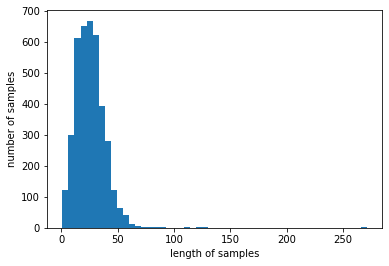

In [9]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [13]:
# 케라스 토그나이저를 통해 정수 인코딩 진행
def tokenize(samples):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(samples)
  return tokenizer

src_tokenizer = tokenize(sentences)
tar_tokenizer = tokenize(pos_tags)

vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('태깅 정보 집합의 크기 : {}'.format(tag_size))

X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(pos_tags)

단어 집합의 크기 : 11388
태깅 정보 집합의 크기 : 47


In [14]:
print(X_train[:2])
print(y_train[:2])

[[5601, 3746, 1, 2024, 86, 331, 1, 46, 2405, 2, 131, 27, 6, 2025, 332, 459, 2026, 3], [31, 3746, 20, 177, 4, 5602, 2915, 1, 2, 2916, 637, 147, 3]]
[[3, 3, 8, 10, 6, 7, 8, 21, 13, 4, 1, 2, 4, 7, 1, 3, 10, 9], [3, 3, 17, 1, 2, 3, 3, 8, 4, 3, 19, 1, 9]]


In [15]:
max_len = 150
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
# X_train의 모든 샘플의 길이를 맞출 때 뒤의 공간에 숫자 0으로 채움.
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)
# y_train의 모든 샘플의 길이를 맞출 때 뒤의 공간에 숫자 0으로 채움.

In [17]:
# 훈련 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2, random_state=777)

In [18]:
# 레이블에 해당하는 태깅 정보에 대해서 원-핫 인코딩 수행
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

In [19]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (2504, 150)
훈련 샘플 레이블의 크기 : (2504, 150, 47)
테스트 샘플 문장의 크기 : (627, 150)
테스트 샘플 레이블의 크기 : (627, 150, 47)


## 양방향 LSTM(Bi-directional LSTM)으로 POS Tagger 만들기



In [20]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
# from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from keras.optimizers import Adam

In [21]:
model = Sequential()
model.add(Embedding(vocab_size, 128, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation=('softmax'))))
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

In [22]:
model.fit(X_train, y_train, batch_size=128, epochs=6,  validation_data=(X_test, y_test))

Epoch 1/6
20/20 [==============================] - 59s 3s/step - loss: 0.5903 - accuracy: 0.1296 - val_loss: 0.5103 - val_accuracy: 0.1530
Epoch 2/6
20/20 [==============================] - 59s 3s/step - loss: 0.5089 - accuracy: 0.1807 - val_loss: 0.4811 - val_accuracy: 0.2704
Epoch 3/6
20/20 [==============================] - 56s 3s/step - loss: 0.4707 - accuracy: 0.3167 - val_loss: 0.4236 - val_accuracy: 0.4412
Epoch 4/6
20/20 [==============================] - 56s 3s/step - loss: 0.3778 - accuracy: 0.4784 - val_loss: 0.3011 - val_accuracy: 0.5426
Epoch 5/6
20/20 [==============================] - 56s 3s/step - loss: 0.2495 - accuracy: 0.6328 - val_loss: 0.1923 - val_accuracy: 0.7242
Epoch 6/6
20/20 [==============================] - 56s 3s/step - loss: 0.1478 - accuracy: 0.8071 - val_loss: 0.1196 - val_accuracy: 0.8403


In [23]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

20/20 [==============================] - 5s 235ms/step - loss: 0.1196 - accuracy: 0.8403

 테스트 정확도: 0.8403


In [24]:
# 인덱스로부터 단어와 품사 태깅 정보를 리턴하는 index_to_word와 index_to_tag를 만들고 이를 이용하여 실제값과 예측값을 출력

index_to_word=src_tokenizer.index_word
index_to_tag=tar_tokenizer.index_word

i=10 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
    if w != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[w], index_to_tag[t].upper(), index_to_tag[pred].upper()))

단어             |실제값  |예측값
-----------------------------------
mr.              : NNP     NNP
simmons          : NNP     NNP
and              : CC      CC
nl               : NNP     NNP
already          : RB      RB
own              : VB      JJ
a                : DT      DT
9.9              : CD      JJ
%                : NN      NN
stake            : NN      NN
in               : IN      IN
georgia          : NNP     NNP
gulf             : NNP     NNP
.                : .       .
